In [20]:
import os
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import cv2
import torch
import torch.nn as nn


In [21]:
label_map = {'black_bear': 0, 'people': 1, 'birds': 2, 'dog': 3, 'brown_bear': 4, 'roe_deer': 5, 'wild_boar': 6, 'amur_tiger': 7, 'amur_leopard': 8, 'sika_deer': 9}
target_size = (224,224)
resize = transforms.Resize(target_size)
centre_crop = transforms.CenterCrop(224)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Look if not working

In [22]:
class RussianWildlifeDataset(Dataset):

    def __init__(self, img_dir):

        self.img_dir = img_dir
        self.data_list = []
        for label in os.listdir(self.img_dir):
            for file in os.listdir(os.path.join(self.img_dir,label)):
                self.data_list.append((file,label))

    def __len__(self):

        return len(self.data_list)

    def __getitem__(self, idx):

        file_name, label = self.data_list[idx]
        img_path = os.path.join(self.img_dir, label, file_name)

        img = torch.from_numpy(cv2.imread(img_path))
        img = img.permute(2, 0, 1)
        img = resize(img)
        # img = centre_crop(img)
        img = img/255
        img = normalize(img)

        return img.float(), label_map[label]

In [23]:
data = RussianWildlifeDataset('data')
print(len(data))

12825


In [24]:
train_size = int(0.7 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_set, val_set, test_set = random_split(data, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=8)

print(len(train_set), len(val_set), len(test_set))

8977 1282 2566


In [54]:
print(len(val_loader))

41


In [25]:
#In case best model is to be runned.
model = resnet18()
model.fc = nn.Linear(512,10,bias=True)
state_dict = torch.load('checkpoints/resnet_best_aug.pt')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [26]:
backbone_model = torch.nn.Sequential(*list(model.children())[:-1])
print(backbone_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [36]:
from sklearn.manifold import TSNE
import numpy as np

backbone_model.eval()  # Set the model to evaluation mode

# Extract features
train_features = []
train_labels = []

for images, labels in train_loader:
    with torch.no_grad():
        output = backbone_model(images)
    train_features.append(output.numpy())
    train_labels.append(labels.numpy())

features_numpy = np.array(train_features[:280])
features_numpy = features_numpy.reshape((280,32,512))
features_numpy = features_numpy.reshape((-1,512))
print(features_numpy.shape)
labels_numpy = np.array(train_labels[:280])
labels_numpy = labels_numpy.reshape((280,32))
labels_numpy = labels_numpy.reshape((-1,1))
print(labels_numpy.shape)

281


trained tsne


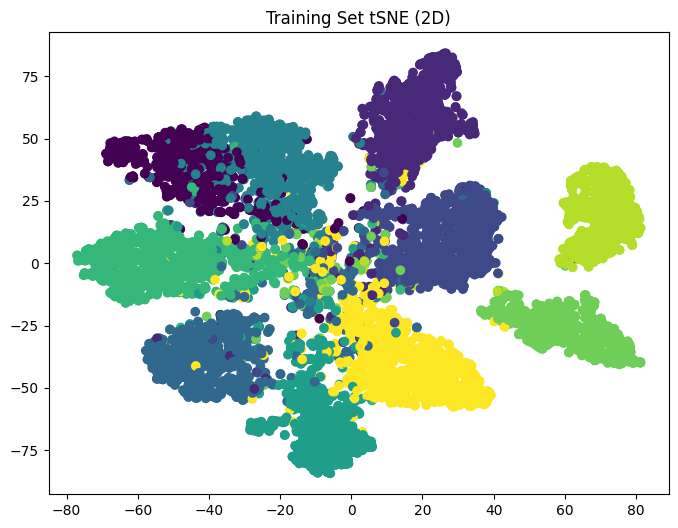

In [52]:
tsne = TSNE(n_components=2, random_state=0)  # 2D tSNE
train_tsne = tsne.fit_transform(features_numpy)

print('trained tsne')
# Create tSNE plots
plt.figure(figsize=(8, 6))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=labels_numpy, cmap='viridis')
plt.title("Training Set tSNE (2D)")
plt.show()



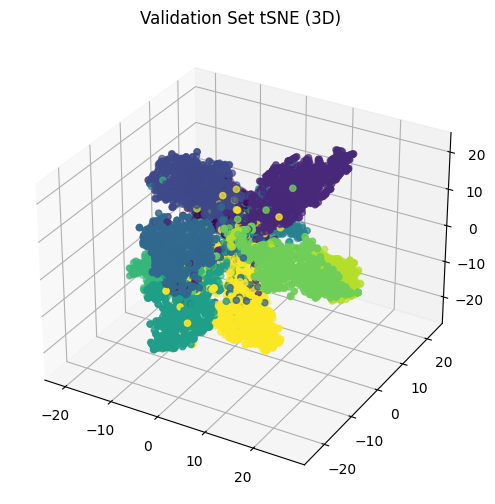

In [53]:
from mpl_toolkits.mplot3d import Axes3D


tsne = TSNE(n_components=3, random_state=0)  # 2D tSNE
train_tsne = tsne.fit_transform(features_numpy)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_tsne[:, 0], train_tsne[:, 1], train_tsne[:, 2], c=labels_numpy, cmap='viridis')
plt.title("Validation Set tSNE (3D)")
plt.show()

In [55]:
backbone_model.eval()  # Set the model to evaluation mode

# Extract features
train_features = []
train_labels = []

for images, labels in val_loader:
    with torch.no_grad():
        output = backbone_model(images)
    train_features.append(output.numpy())
    train_labels.append(labels.numpy())

features_numpy = np.array(train_features[:40])
features_numpy = features_numpy.reshape((40,32,512))
features_numpy = features_numpy.reshape((-1,512))
print(features_numpy.shape)
labels_numpy = np.array(train_labels[:40])
labels_numpy = labels_numpy.reshape((40,32))
labels_numpy = labels_numpy.reshape((-1,1))
print(labels_numpy.shape)

(1280, 512)
(1280, 1)


trained tsne


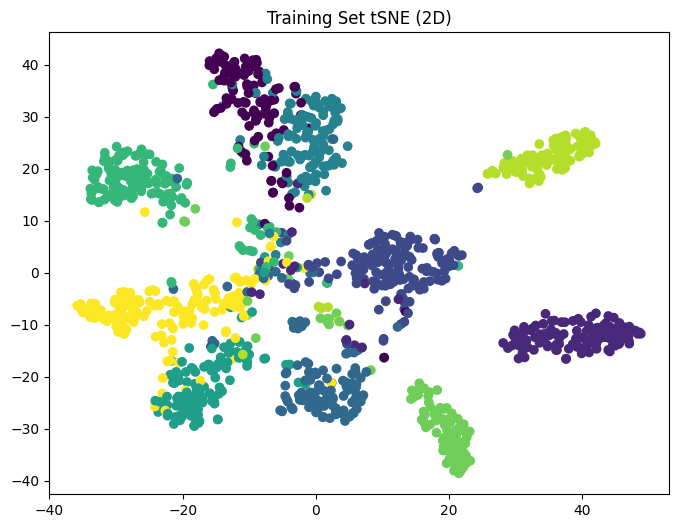

In [56]:
tsne = TSNE(n_components=2, random_state=0)  # 2D tSNE
train_tsne = tsne.fit_transform(features_numpy)

print('trained tsne')
# Create tSNE plots
plt.figure(figsize=(8, 6))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=labels_numpy, cmap='viridis')
plt.title("Training Set tSNE (2D)")
plt.show()



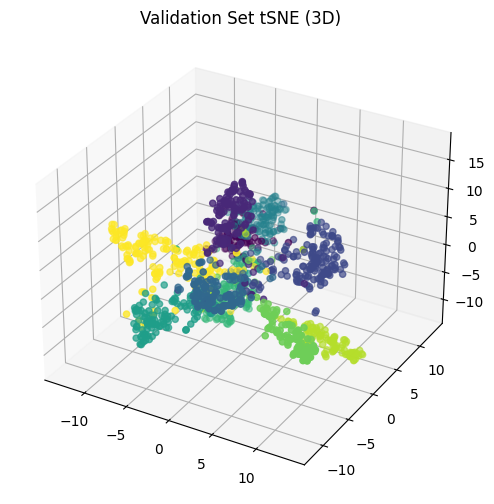

In [57]:
from mpl_toolkits.mplot3d import Axes3D


tsne = TSNE(n_components=3, random_state=0)  # 2D tSNE
train_tsne = tsne.fit_transform(features_numpy)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_tsne[:, 0], train_tsne[:, 1], train_tsne[:, 2], c=labels_numpy, cmap='viridis')
plt.title("Validation Set tSNE (3D)")
plt.show()